In [109]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import kagglehub
import mediapipe as mp
import json
from IPython.display import HTML

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
path = kagglehub.dataset_download("soumicksarker/ipn-hand-dataset")
print(path)

/Users/steventan/.cache/kagglehub/datasets/soumicksarker/ipn-hand-dataset/versions/7


In [3]:
df = pd.read_csv(os.path.join(path, "metadata.csv"))
df.head()

,Video Name,Frames,Sex,Hand,Background,Illumination,People in Scene,Background Motion,Set,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,1CM1_4_R__229,3751,W,Right,Clutter,Stable,Single,Static,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1CM1_4_R__230,3684,W,Right,Clutter,Stable,Single,Static,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1CM1_4_R__231,3747,W,Right,Clutter,Stable,Single,Static,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1CM1_4_R__232,3858,W,Right,Clutter,Stable,Single,Static,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1CM42_11_R__205,3686,M,Right,Plain,Stable,Single,Static,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
annotations_path = os.path.join(path, "annotations/annotations")
with open(os.path.join(annotations_path, "class_details.txt"), 'r') as f:
    for row in f:
        print(row)

id	Label	Gesture	Instances		 

1	D0X	Non-gesture		 

2	B0A	Pointing with one finger		 

3	B0B	Pointing with two fingers		 

4	G01	Click with one finger	 

5	G02	Click with two fingers	

6	G03	Throw up	

7	G04	Throw down	

8	G05	Throw left	 

9	G06	Throw right	 

10	G07	Open twice	

11	G08	Double click with one finger	 

12	G09	Double click with two fingers	

13	G10	Zoom in	

14	G11	Zoom out	 



In [5]:
def read_annotations(path):
    with open(path, 'r') as f:
        annots = []
        for idx, line in enumerate(f):
            if idx > 0:
                # Parse annotations and convert frame info into ints
                info = line.split(',')
                for i in range(2, len(info)):
                    info[i] = int(info[i])
                annots.append(info)
    return annots

In [75]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

class IPNDataPreProcessor:
    def __init__(self, annots, dset_path, out_path):
        self.out_path = out_path
        self.dset_path = dset_path
        self.videos_path = os.path.join(dset_path, "videos/videos")
        
        self.annots = annots
        self.n = len(annots)
        
        self.hands = mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.2,
            min_tracking_confidence=0.2,
        )

        # Constants
        self.min_frames = 5
        self.num_frames = 210

    def get_frames(self, video_name, start_frame, end_frame):
        video_path = os.path.join(self.videos_path, video_name + ".avi")
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        if not cap.isOpened():
            raise FileNotFoundError(f"Video file not found: {video_path}")
    
        frames = []
        for frame_i in range(start_frame, end_frame):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return frames

    def get_annotation(self, idx):
        info = self.annots[idx]
        video_name, label, label_id, start_frame, end_frame, num_frames = info
        frames = self.get_frames(video_name, start_frame, end_frame)
        return frames, label_id

    # Extracts skeletons using mediapipe from a list of frames, removes missing frames at the start and end, 
    # and interpolates frames in the middle. Will repeat frames (upsample) or downsample to reach exactly self.num_frames.
    def extract_skeleton_sequence(self, frames, annot_idx):
        seq = []
        missing = []

        first_valid = -1
        last_valid = -1
        avail = 0
        for i, frame in enumerate(frames):
            result = self.hands.process(frame)
    
            if result.multi_hand_landmarks:
                landmarks = result.multi_hand_landmarks[0].landmark
                seq.append(torch.tensor([[lm.x, lm.y, lm.z] for lm in landmarks], dtype=torch.float32))
                
                if first_valid == -1:
                    first_valid = i
                last_valid = i
                avail += 1
            else:
                seq.append(None)
                missing.append(i)
    
        # If too few frames, discard
        if avail < self.min_frames:
            return None
    
        # Slice seq to remove missing frames at start and end
        seq = seq[first_valid : last_valid + 1]
        
        # Interpolate missing frames in the middle
        prev = 0
        for i in range(1, len(seq)):
            if seq[i] is not None:
                for j in range(prev + 1, i):       
                    # Linear interpolation
                    alpha = (j - prev) / (i - prev)
                    seq[j] = (1 - alpha) * seq[prev] + alpha * seq[i]
                prev = i
    
        
        seq = torch.stack(seq)
        T = seq.shape[0]
        
        if T == self.num_frames:
            return seq
    
        if T > self.num_frames:
            # Downsample evenly
            idx = torch.linspace(0, T - 1, self.num_frames).long()
            seq = seq[idx]
        else:
            # Upsample by cycling frames instead of repeating last
            extra = self.num_frames - T
            cycle_idx = torch.arange(extra) % T
            pad = seq[cycle_idx]
            seq = torch.cat([seq, pad], dim=0)
    
        return seq

    def extract_all_skeletons(self):
        metadata = {"samples": []}
        skel_list = []

        valid_cnt = 0
        for idx, info in enumerate(self.annots):
            video_name, label, label_id, start_frame, end_frame, num_frames = info
            
            # Extract frames
            frames = self.get_frames(video_name, start_frame, end_frame)
            
            # Extract skeletons and track missing
            skeleton_seq = self.extract_skeleton_sequence(frames, idx)
            
            # If video is missing too much data (can't extract skeletons), then discard
            if skeleton_seq is None:
                print(f"Discarded: {info}")
                continue

            assert skeleton_seq.shape[0] == self.num_frames
            skel_list.append(skeleton_seq)
            
            # Store metadata
            metadata["samples"].append({
                "idx": idx,
                "skel_idx": valid_cnt,
                "video": video_name,
                "label": label,
                "label_id": label_id,
                "start_frame": start_frame,
                "end_frame": end_frame,
                "num_frames": num_frames
            })
            valid_cnt += 1

            if idx > 0 and idx % 100 == 0:
                print(f"Processed {idx} gestures")

        # Save all skeletons as tensor
        skel_tensor = torch.stack(skel_list)
        torch.save(skel_tensor, os.path.join(self.out_path, "skeletons_tensor.pt"))
        
        # Save skeleton metadata
        meta_path = os.path.join(self.out_path, "skeleton_annots.json")
        with open(meta_path, "w") as f:
            json.dump(metadata, f, indent=2)

        print(f"Saved all skeletons and metadata to {self.dset_path}")
        print(f"Missing frames info saved to {missing_path}")

In [107]:
train_annots = read_annotations(os.path.join(annotations_path, "Annot_TrainList.txt"))
test_annots = read_annotations(os.path.join(annotations_path, "Annot_TestList.txt"))
print(len(train_annots), len(test_annots))

4038 1609


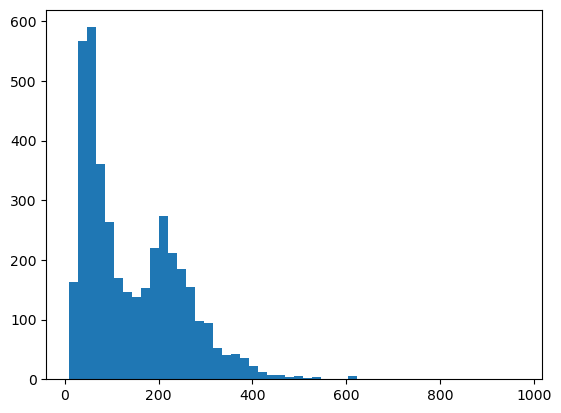

In [106]:
gest_lens = np.array([info[-1] for info in train_annots])
plt.hist(gest_lens, bins=50)
plt.show()

In [ ]:
train_dataset = IPNDataPreProcessor(train_annots, path, os.path.join(path, "train_skeletons"))
train_dataset.extract_all_skeletons()

In [171]:
train_dataset = IPNDataPreProcessor(test_annots, path, os.path.join(path, "test_skeletons"))
train_dataset.extract_all_skeletons()

I0000 00:00:1763172404.938768 204059605 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4
W0000 00:00:1763172404.956687 205874647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763172404.962784 205874647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Discarded: ['1CM1_1_R__217', 'G03', 6, 1884, 1938, 55]
Discarded: ['1CM1_1_R__217', 'G02', 5, 2861, 2906, 46]
Discarded: ['1CM1_1_R__217', 'G08', 11, 3388, 3414, 27]
Discarded: ['1CM1_1_R__218', 'D0X', 1, 1, 19, 19]
Discarded: ['1CM1_1_R__218', 'G02', 5, 1041, 1074, 34]
Discarded: ['1CM1_1_R__218', 'G07', 10, 1906, 1945, 40]
Discarded: ['1CM1_1_R__218', 'G11', 14, 2491, 2543, 53]
Discarded: ['1CM1_1_R__219', 'D0X', 1, 1, 21, 21]
Discarded: ['1CM1_1_R__219', 'D0X', 1, 1131, 1500, 370]
Discarded: ['1CM1_1_R__219', 'D0X', 1, 2682, 3016, 335]
Discarded: ['1CM1_1_R__219', 'D0X', 1, 3865, 3921, 57]
Discarded: ['1CM1_1_R__220', 'D0X', 1, 1, 25, 25]
Processed 100 gestures
Discarded: ['1CM1_1_R__220', 'D0X', 1, 3837, 3889, 53]
Discarded: ['1CM1_2_R__222', 'D0X', 1, 1, 29, 29]
Discarded: ['1CM1_2_R__222', 'D0X', 1, 1442, 1493, 52]
Discarded: ['1CM1_2_R__222', 'D0X', 1, 2764, 2874, 111]
Processed 200 gestures
Discarded: ['1CM1_2_R__223', 'D0X', 1, 1034, 1059, 26]
Discarded: ['1CM1_2_R__224', 'D0X

/opt/miniconda3/envs/dev/lib/python3.9/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Processed 300 gestures
Discarded: ['1CM1_3_R__225', 'D0X', 1, 4186, 4260, 75]
Discarded: ['1CM1_3_R__226', 'D0X', 1, 4769, 4795, 27]
Discarded: ['1CM1_3_R__228', 'D0X', 1, 4170, 4176, 7]
Processed 400 gestures
Discarded: ['1CM42_15_R__198', 'D0X', 1, 4426, 4465, 40]
Discarded: ['1CM42_15_R__199', 'D0X', 1, 4220, 4243, 24]
Discarded: ['1CM42_30_R__145', 'D0X', 1, 1, 63, 63]
Processed 500 gestures
Discarded: ['1CM42_30_R__145', 'D0X', 1, 3715, 3760, 46]
Discarded: ['1CM42_30_R__148', 'D0X', 1, 1, 41, 41]
Discarded: ['1CM42_31_R__129', 'D0X', 1, 1, 30, 30]
Processed 600 gestures
Processed 700 gestures
Discarded: ['1CV12_12_R__89', 'D0X', 1, 3683, 3977, 295]
Discarded: ['1CV12_12_R__89', 'D0X', 1, 4370, 4395, 26]
Discarded: ['1CV12_12_R__90', 'D0X', 1, 1, 112, 112]
Discarded: ['1CV12_12_R__91', 'D0X', 1, 1, 72, 72]
Discarded: ['1CV12_12_R__92', 'D0X', 1, 1, 134, 134]
Discarded: ['1CV12_12_R__92', 'D0X', 1, 4720, 4772, 53]
Processed 800 gestures
Processed 900 gestures
Discarded: ['1CV12_15_

In [120]:
# Edge list from Mediapipe HAND_CONNECTIONS

MEDIAPIPE_EDGES = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (0,9),(9,10),(10,11),(11,12),
    (0,13),(13,14),(14,15),(15,16),
    (0,17),(17,18),(18,19),(19,20),
]

def animate_skeleton_sequence(seq, interval=50):
    T = seq.shape[0]

    # Extract the first frame’s 2D positions
    first = seq[0][:, :2]

    plt.close('all')
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.axis('off')

    scat = ax.scatter(first[:, 0], first[:, 1], s=20)

    lines = []
    for (a, b) in MEDIAPIPE_EDGES:
        ln, = ax.plot(
            [first[a,0], first[b,0]],
            [first[a,1], first[b,1]],
            linewidth=2
        )
        lines.append(ln)

    def update(i):
        joints = seq[i][:, :2]

        scat.set_offsets(joints)

        for ln, (a, b) in zip(lines, MEDIAPIPE_EDGES):
            ln.set_data(
                [joints[a,0], joints[b,0]],
                [joints[a,1], joints[b,1]]
            )

        return [scat] + lines

    ani = animation.FuncAnimation(
        fig, update, frames=T, interval=interval, blit=False
    )
    return ani

In [115]:
skel_data = torch.load(os.path.join(path, "train_skeletons/skeletons_tensor.pt"))

with open(os.path.join(path, "train_skeletons/skeleton_annots.json"), 'r') as file:
    skel_metadata = json.load(file)
skel_metadata

/var/folders/_1/ph20kymj4s9bnnn49x3mjlxr0000gn/T/ipykernel_24563/2474470438.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  skel_data = torch.load(os.path.join(path, "tr

{'samples': [{'idx': 0,
   'skel_idx': 0,
   'video': '1CM1_4_R__229',
   'label': 'G11',
   'label_id': 14,
   'start_frame': 18,
   'end_frame': 55,
   'num_frames': 38},
  {'idx': 1,
   'skel_idx': 1,
   'video': '1CM1_4_R__229',
   'label': 'B0B',
   'label_id': 3,
   'start_frame': 56,
   'end_frame': 284,
   'num_frames': 229},
  {'idx': 2,
   'skel_idx': 2,
   'video': '1CM1_4_R__229',
   'label': 'G04',
   'label_id': 7,
   'start_frame': 285,
   'end_frame': 308,
   'num_frames': 24},
  {'idx': 3,
   'skel_idx': 3,
   'video': '1CM1_4_R__229',
   'label': 'B0B',
   'label_id': 3,
   'start_frame': 309,
   'end_frame': 502,
   'num_frames': 194},
  {'idx': 4,
   'skel_idx': 4,
   'video': '1CM1_4_R__229',
   'label': 'G05',
   'label_id': 8,
   'start_frame': 503,
   'end_frame': 544,
   'num_frames': 42},
  {'idx': 5,
   'skel_idx': 5,
   'video': '1CM1_4_R__229',
   'label': 'B0B',
   'label_id': 3,
   'start_frame': 545,
   'end_frame': 857,
   'num_frames': 313},
  {'idx': 

{'idx': 1036, 'skel_idx': 1012, 'video': '1CM42_4_R__185', 'label': 'B0A', 'label_id': 2, 'start_frame': 332, 'end_frame': 593, 'num_frames': 262}


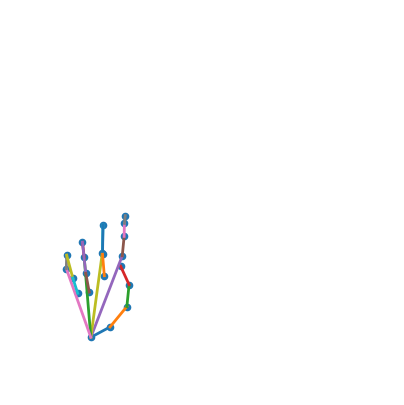

In [169]:
skel_idx = 1012
print(skel_metadata["samples"][skel_idx])
ani = animate_skeleton_sequence(skel_data[skel_idx])
HTML(ani.to_jshtml())